In [1]:
import numpy as np
import matplotlib.pyplot as plt
import skfuzzy as fuzz
import pandas as pd
import skfuzzy as fuzz
from functools import partial

In [2]:
def distance_weighted(x,y,mu):
    return np.sum(np.array(mu)*(x-y)**2)

### Preprocessing

In [3]:
def generate_subsequences(data, window_size, step_size):
    num_points, num_variables = data.shape
    number_subs = int((num_points - window_size)/step_size) + 1  # Number of subsequences

    subsequences = np.zeros((number_subs, window_size, num_variables))

    for i in range(number_subs):
        subsequences[i, :, :] = data[i*step_size:i*step_size+window_size, :]
    return subsequences

def reconstructed_loss(reconstructed_points, initial_points):
    return np.linalg.norm(reconstructed_points - initial_points, ord=2, axis=1)


#### BATADAL

In [ ]:
train_data_batadal = pd.read_csv('data/BATADAL/BATADAL_dataset04.csv')


In [ ]:
train_data[" ATT_FLAG"].value_counts()
df_np_label = train_data.drop(["DATETIME", " ATT_FLAG"], axis=1).values


In [ ]:
window_size = 10
stride = 5
sequences = generate_subsequences(df_np_label, window_size, stride)
label_sequences = generate_subsequences(train_data[" ATT_FLAG"].values.reshape(-1,1), window_size, stride)

#### SWAT

In [4]:
train_data = pd.read_csv('data/swat/SWaT_test.csv')

In [5]:
train_data["Normal/Attack"] = train_data["Normal/Attack"].replace({"Normal": 0, "Attack": 1})


In [6]:
train_data["Normal/Attack"].value_counts()
df_np_label = train_data.drop([" Timestamp", "Normal/Attack"], axis=1).values

### Data analysis

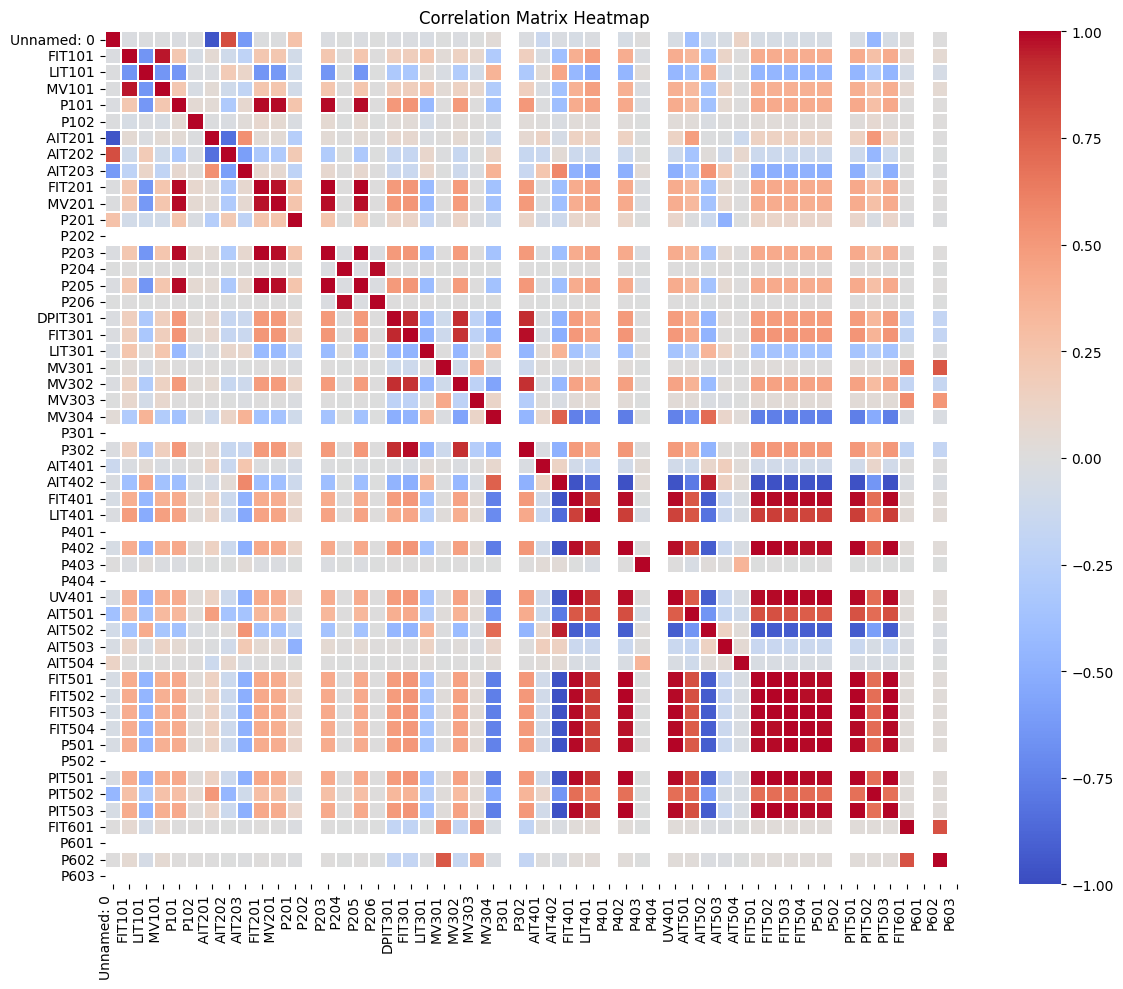

In [7]:
import seaborn as sns

corr = train_data.drop(columns = [" Timestamp", "Normal/Attack"]).corr()
# Create a heatmap with rotated axis labels
plt.figure(figsize=(12, 10))
#sns.heatmap(corr, xticklabels=True, yticklabels=True)

sns.heatmap(corr, annot=False, cmap='coolwarm', fmt=".2f", linewidths=0.05, vmin=-1, vmax=1, xticklabels = True, yticklabels = True)
plt.title('Correlation Matrix Heatmap')

# Rotate the axis labels for better visibility
plt.xticks(rotation=90, ha='right')  # Adjust the rotation angle and alignment as needed
plt.yticks(rotation=0)
plt.tight_layout()  # Ensures all labels are visible

plt.show()

# constant_channel_names = ["P603", "P601", "P502", "P404", "P403", "P401", "P206", " P204", " P202", " P201", "P102", "P301"]
# corr_without_ct = train_data.drop(columns = constant_channel_names + ["Unnamed: 0","Normal/Attack"]).corr()


#### PCA on array

In [8]:
#data_without_cte = train_data.drop(columns = constant_channel_names + ["Unnamed: 0","Normal/Attack"]).values
#df_np_label_reduced = data_without_cte[::, 1:]
data_np = train_data.drop(columns = ["Unnamed: 0","Normal/Attack", " Timestamp"]).values

In [9]:
import numpy as np
from sklearn.decomposition import PCA

# Create a PCA instance
n_components_analysis = 20
pca = PCA(n_components = n_components_analysis)

# Fit the data and transform it
data_pca = pca.fit_transform(data_np)



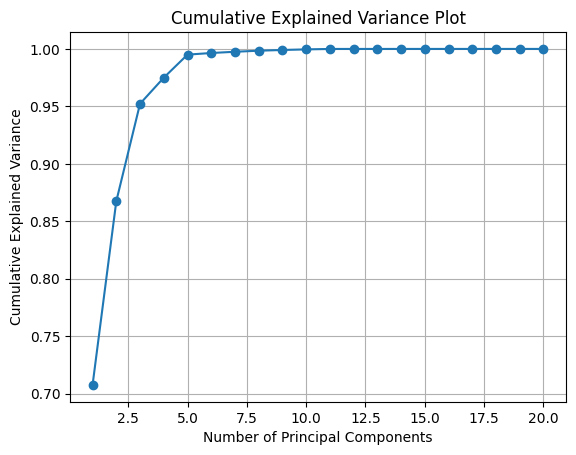

[0.70763667 0.86754367 0.9522937  0.97496631 0.99503435 0.99644622
 0.99752941 0.99844056 0.9990747  0.99960153 0.99996889 0.99998065
 0.99998801 0.99999348 0.9999954  0.99999636 0.99999719 0.99999796
 0.99999868 0.99999896]


In [10]:
# Check the explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_

# Cumulative explained variance
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

# Plot the cumulative explained variance
plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='o')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance Plot')
plt.grid(True)
plt.show()
print(cumulative_explained_variance)

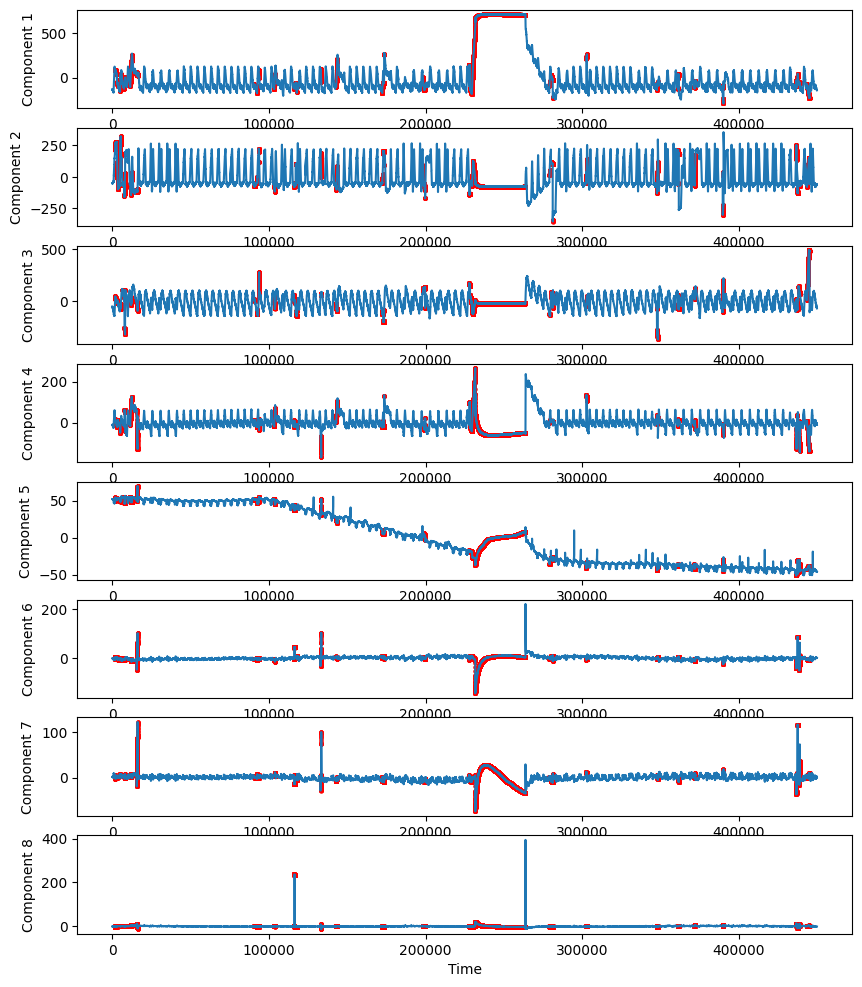

In [11]:
labels = train_data["Normal/Attack"].values
label_1_indices = np.where(labels == 1)[0]

# Plot the first 5 components in 5 subplots
fig, axes = plt.subplots(8, 1, figsize=(10, 12))

for i in range(8):
    axes[i].plot(data_pca[:, i])
    axes[i].scatter(label_1_indices, data_pca[label_1_indices, i],s=5,c = "red", label='Label 1')
    axes[i].set_ylabel(f'Component {i+1}')

plt.xlabel('Time')
plt.show()

### Find main frequencies

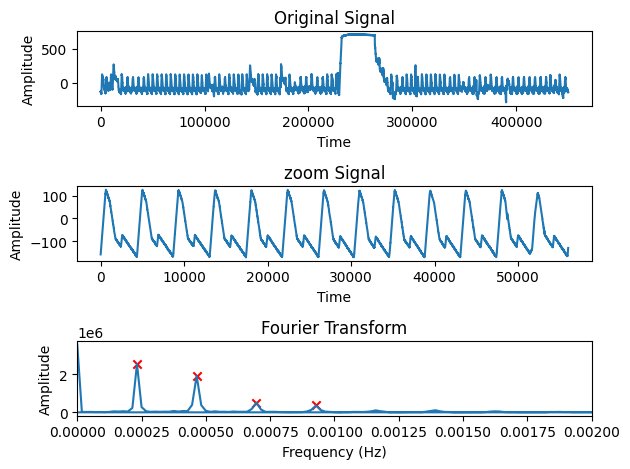

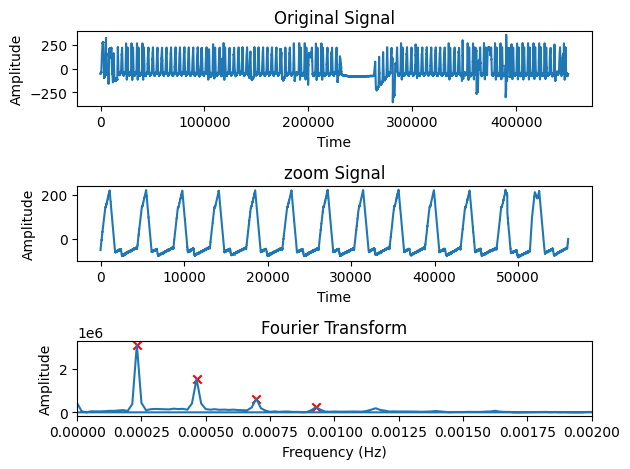

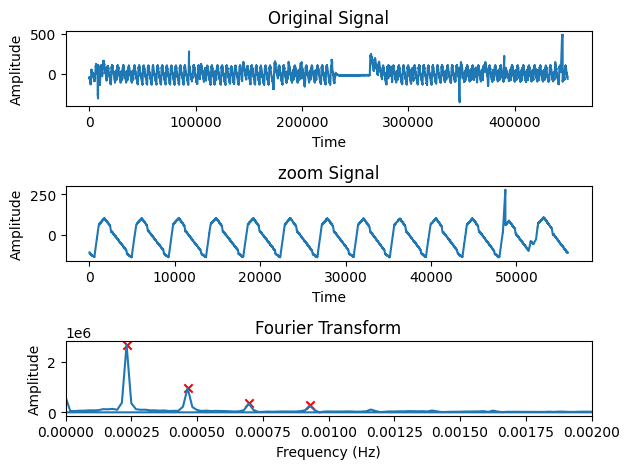

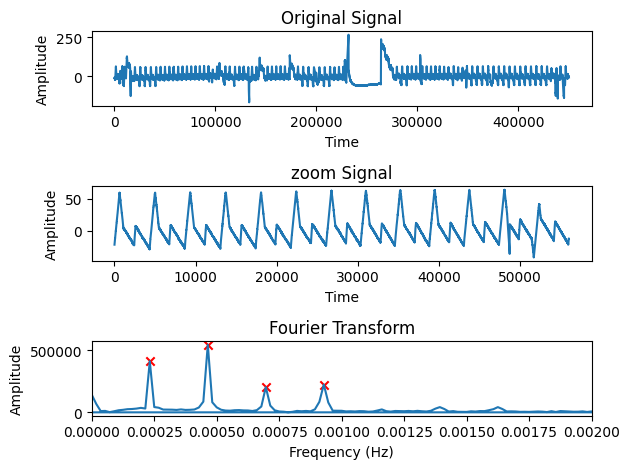

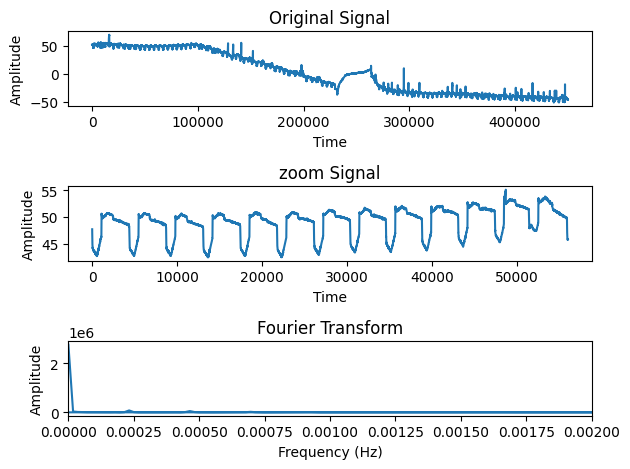

In [12]:
from scipy.signal import find_peaks
n_components = 5
periodicity = []
for i in range(n_components):
    signal_periodic = data_pca[45000:101000, i]
    fourier_transform = np.fft.fft(signal_periodic)
    frequencies = np.fft.fftfreq(len(signal_periodic), 1)

    peaks, _ = find_peaks(np.abs(fourier_transform), height=0.2e6)
    periodicity.append(1/frequencies[peaks[:3]])
    plt.subplot(3, 1, 1)
    plt.plot( data_pca[:, i])
    plt.title('Original Signal')
    plt.xlabel('Time')
    plt.ylabel('Amplitude')

    plt.subplot(3, 1, 2)
    plt.plot( signal_periodic)
    plt.title('zoom Signal')
    plt.xlabel('Time')
    plt.ylabel('Amplitude')

    plt.subplot(3, 1, 3)
    plt.plot(frequencies, np.abs(fourier_transform))
    plt.scatter(frequencies[peaks], np.abs(fourier_transform)[peaks], color='red', marker='x', label='Local Maxima')

    plt.title('Fourier Transform')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Amplitude')
    plt.xlim(0,0.002)
    plt.tight_layout()
    plt.show()


In [13]:
print(periodicity)

[array([4307.69230769, 2153.84615385, 1435.8974359 ]), array([4307.69230769, 2153.84615385, 1435.8974359 ]), array([4307.69230769, 2153.84615385, 1435.8974359 ]), array([4307.69230769, 2153.84615385, 1435.8974359 ]), array([], dtype=float64)]


In [14]:
main_periodicity = periodicity[0][0]
print("Main periodicity in seconds", main_periodicity)
downsampling_rate = int(main_periodicity/40)

Main periodicity in seconds 4307.692307692308


#### Downsampled signals

In [15]:
class DownSamplerSignal:
    def __init__(self, downsampling_rate):
        self.downsampling_rate = downsampling_rate

    def downsample_signal(self, signal , downsampling_rate):
        self.initial_shape = len(signal)
        self.downsampling_rate = downsampling_rate
        return signal[::downsampling_rate]

    def upsample_signal(self, signal):
        print(np.repeat(signal, downsampling_rate))
        return np.repeat(signal, downsampling_rate, axis=0)[:self.initial_shape]

In [16]:
downsampler = DownSamplerSignal(downsampling_rate)
data_pca_downsampled = downsampler.downsample_signal(data_pca, downsampling_rate)
labels_downsampled = downsampler.downsample_signal(labels, downsampling_rate)


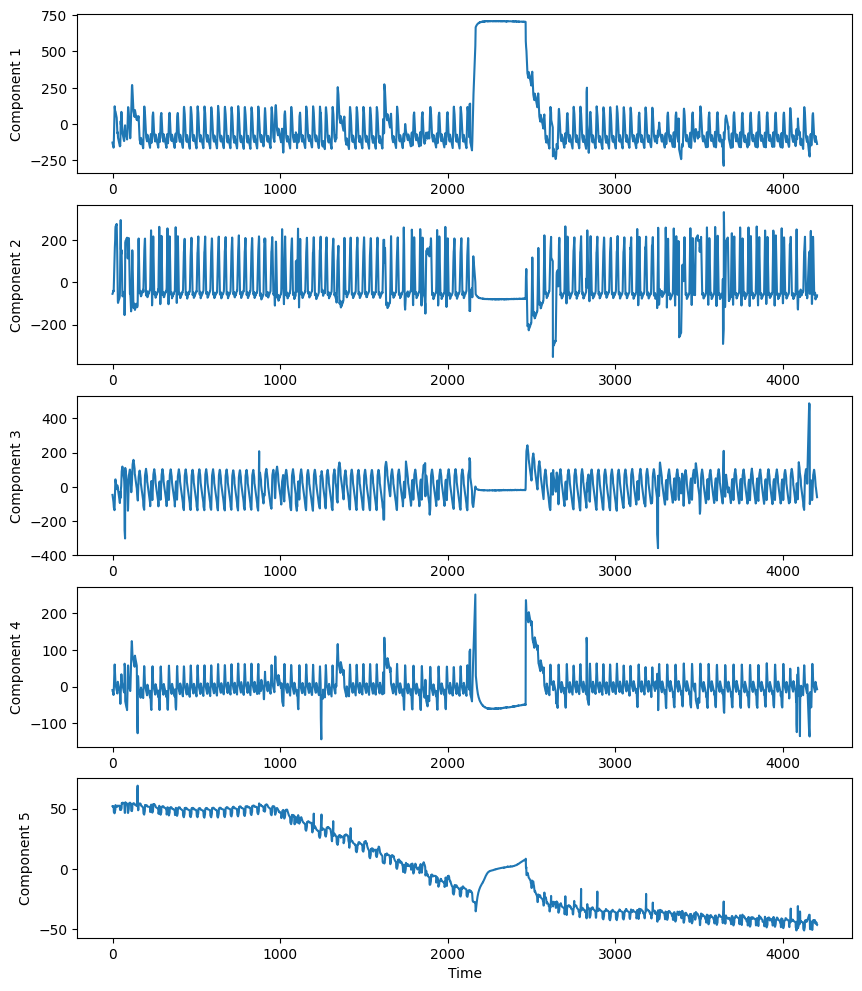

In [17]:
# Plot the first 5 components in 5 subplots
fig, axes = plt.subplots(5, 1, figsize=(10, 12))

for i in range(5):
    axes[i].plot(data_pca_downsampled[:, i])
    axes[i].set_ylabel(f'Component {i+1}')

plt.xlabel('Time')
plt.show()

[-1.27800274e+02 -1.27800274e+02 -1.27800274e+02 ... -1.04790728e-02
 -1.04790728e-02 -1.04790728e-02]


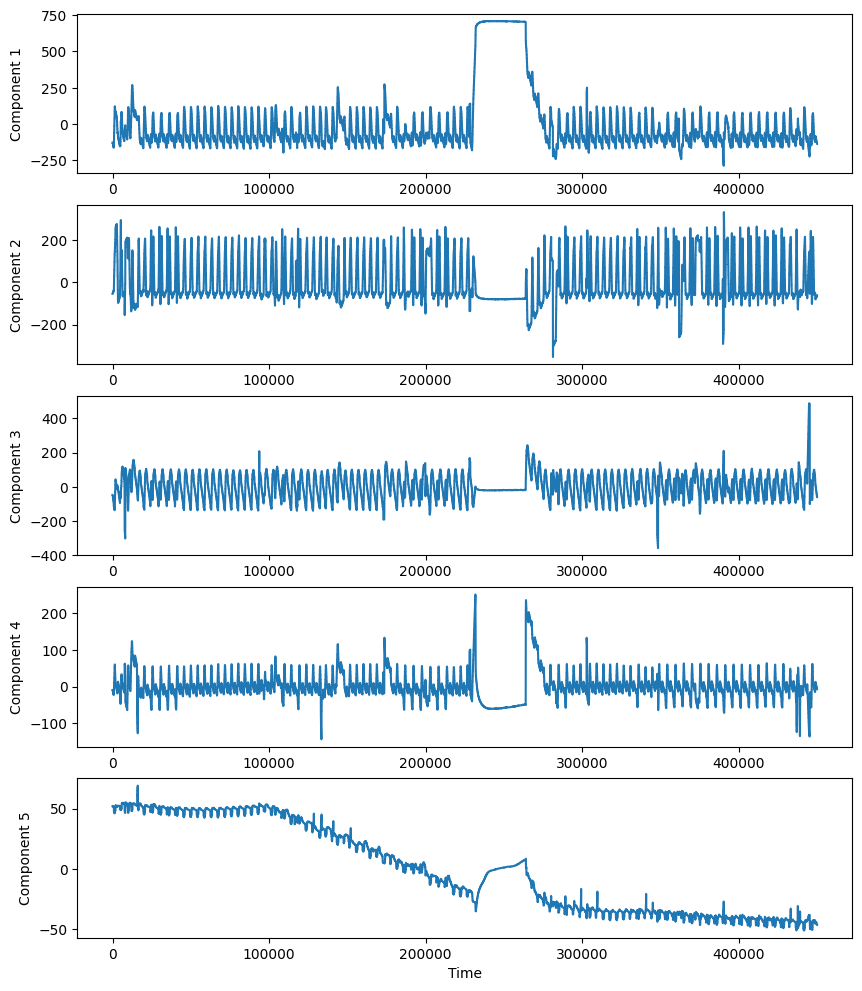

In [18]:
data_pca_upsampled = downsampler.upsample_signal(data_pca_downsampled)
# Plot the first 5 components in 5 subplots
fig, axes = plt.subplots(5, 1, figsize=(10, 12))

for i in range(5):
    axes[i].plot(data_pca_upsampled[:, i])
    axes[i].set_ylabel(f'Component {i+1}')

plt.xlabel('Time')
plt.show()

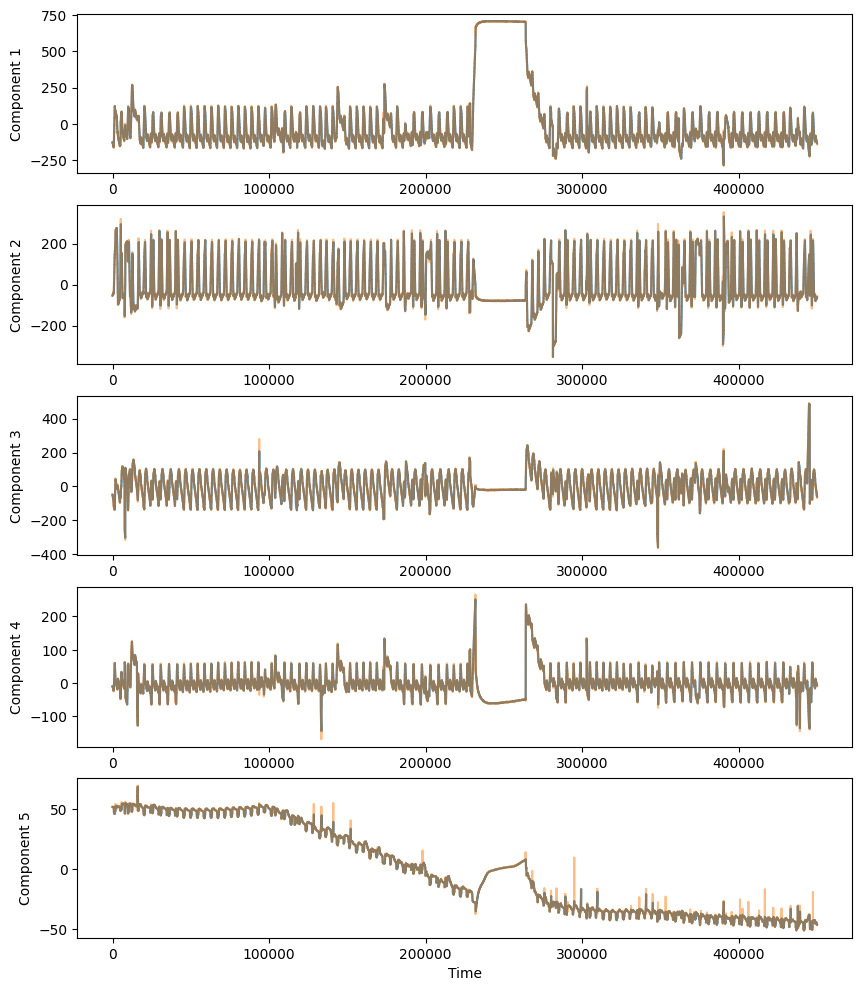

In [19]:
fig, axes = plt.subplots(5, 1, figsize=(10, 12))

for i in range(5):
    axes[i].plot(data_pca_upsampled[:, i])
    axes[i].plot(data_pca[:, i], alpha=0.5)
    axes[i].set_ylabel(f'Component {i+1}')

plt.xlabel('Time')
plt.show()

#### Generate subsequences of signals after PCA

In [20]:
window_size = int(main_periodicity/downsampling_rate)

stride =int(window_size/5)
sequences = generate_subsequences(data_pca_downsampled[:,:n_components], window_size, stride)
label_sequences = generate_subsequences(train_data["Normal/Attack"].values.reshape(-1,1)[::downsampling_rate], window_size, stride)

print("window size = ", window_size)
print("stride = ", stride)

window size =  40
stride =  8


In [21]:
data_for_clustering = sequences.reshape(sequences.shape[0], -1)
mu = [1/data_for_clustering.shape[1] for i in range(data_for_clustering.shape[1])]

cntr, u, _, _, _, _, _ = fuzz.cluster.cmeans(data_for_clustering.T, 3, 2,metric = partial(distance_weighted, mu = mu), error=0.005, maxiter=1000, init=None)

# Reconstruction of initial points
reconstructed_points = np.dot(u.T, cntr) / np.sum(u, axis=0)[:, None]



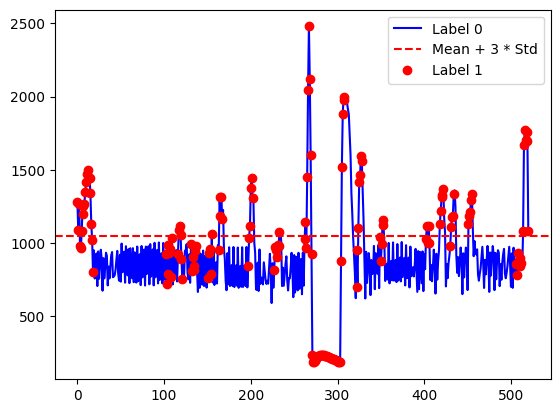

In [22]:
loss = reconstructed_loss(reconstructed_points, data_for_clustering)
label_reshaped = np.max(label_sequences, axis=1)
# Select points with label 1
label_1_indices = np.where(label_reshaped == 1)[0]

#plot loss
plt.plot(range(len(loss)), loss, color='blue', label='Label 0')
# Calculate mean and standard deviation
mean_loss = np.mean(loss)
std_loss = np.std(loss)

# Set the threshold for the line (mean + 3 * std)
threshold = mean_loss + 0.5 * std_loss
plt.axhline(y=threshold, color='r', linestyle='--', label='Mean + 3 * Std')

# Plot red points for anomalies
plt.plot(label_1_indices, loss[label_1_indices], 'ro', label='Label 1')
plt.legend()


#### Reconstruction Labels

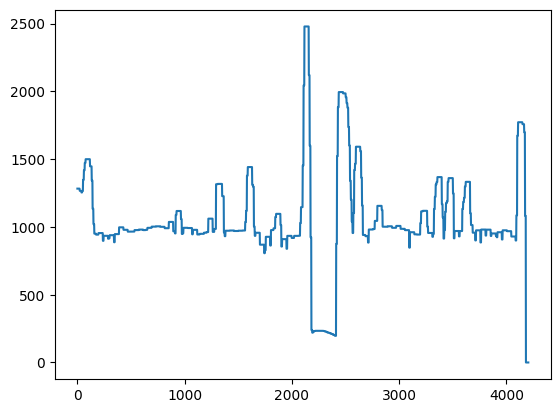

In [23]:
def aggregate_anomaly_scores(anomaly_scores, window_size, stride, signal_length):
    # Initialize the aggregated signal
    aggregated_signal = np.zeros(signal_length)
    gaussian_kernel = np.exp(-np.linspace(-1, 1, window_size)**2)
    # Iterate over each window and assign its score to the corresponding positions in the aggregated signal
    for i, score in enumerate(anomaly_scores):
        start_idx = max(0, i*stride - window_size // 2)
        end_idx = min(signal_length, i*stride + window_size // 2 + 1)
        aggregated_signal[start_idx:end_idx] = np.maximum(aggregated_signal[start_idx:end_idx], score)
    return aggregated_signal


aggregated_signal_reduced = aggregate_anomaly_scores(loss, window_size, stride,  len(train_data["Normal/Attack"].values.reshape(-1,1)[::downsampling_rate]))
plt.figure()
plt.plot(aggregated_signal_reduced)

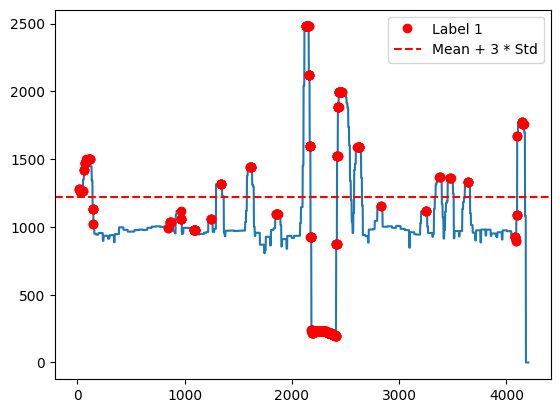

In [25]:
labels = train_data["Normal/Attack"].values[::downsampling_rate]
label_1_indices_initial = np.where(labels == 1)[0]
plt.plot(aggregated_signal_reduced)
# Set the threshold for the line (mean + 3 * std)
threshold = np.mean(aggregated_signal_reduced) + 0.5 * np.std(aggregated_signal_reduced)
plt.plot(label_1_indices_initial, aggregated_signal_reduced[label_1_indices_initial], 'ro', label='Label 1')

plt.axhline(y=threshold, color='r', linestyle='--', label='Mean + 3 * Std')

plt.legend()

#### Evaluation

In [26]:
predicted_labels = aggregated_signal_reduced > threshold
predicted_labels = predicted_labels.astype(int)

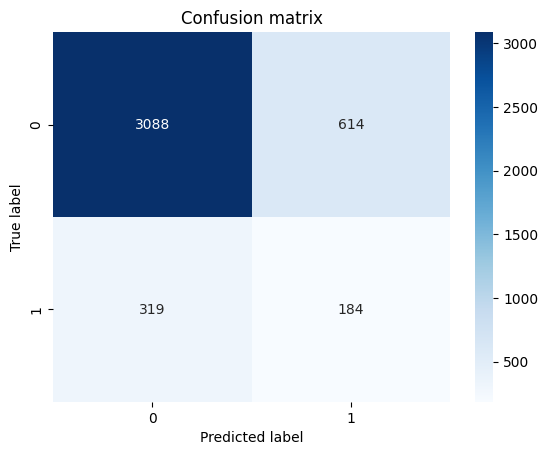

In [27]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(labels, predicted_labels)
label_possible = np.unique(labels)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_possible, yticklabels=label_possible)
plt.title("Confusion matrix")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()



In [28]:
from evaluation import compute_metrics
dict_metrics = compute_metrics(labels, predicted_labels)



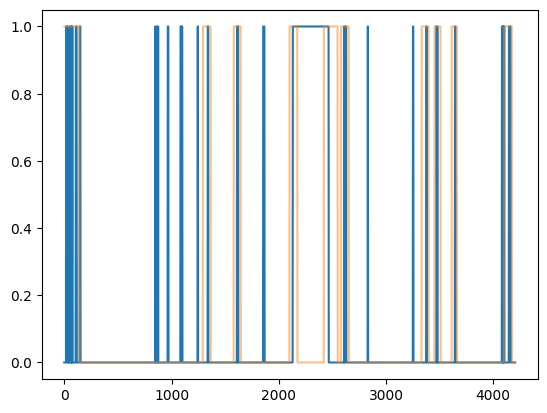

In [30]:
plt.plot(labels)
plt.plot(predicted_labels, alpha=0.5)

In [31]:
from prts import ts_precision, ts_recall

precision_flat = ts_precision(labels, predicted_labels, alpha=0.3, cardinality="reciprocal", bias="flat")
precision_front = ts_precision(labels, predicted_labels, alpha=0.3, cardinality="reciprocal", bias="front")
precision_middle = ts_precision(labels, predicted_labels, alpha=0.3, cardinality="reciprocal", bias="middle")
precision_back = ts_precision(labels, predicted_labels, alpha=0.3, cardinality="reciprocal", bias="back")
print("precision_flat=", precision_flat)
print("precision_front=", precision_front)
print("precision_middle=", precision_middle)
print("precision_back=", precision_back)

# calculate time series recall score
recall_flat = ts_recall(labels, predicted_labels, alpha=0.3, cardinality="reciprocal", bias="flat")
recall_front = ts_recall(labels, predicted_labels, alpha=0.3, cardinality="reciprocal", bias="front")
recall_middle = ts_recall(labels, predicted_labels, alpha=0.3, cardinality="reciprocal", bias="middle")
recall_back = ts_recall(labels, predicted_labels, alpha=0.3, cardinality="reciprocal", bias="back")
print("recall_flat=", recall_flat)
print("recall_front=", recall_front)
print("recall_middle=", recall_middle)
print("recall_back=", recall_back)

precision_flat= 0.4081879899443174
precision_front= 0.39857488059716795
precision_middle= 0.4198227596145518
precision_back= 0.4178010992914668
recall_flat= 0.5573315241971959
recall_front= 0.5572849766319916
recall_middle= 0.555289877946128
recall_back= 0.5573780717624002


### Optimization PSO

In [ ]:
def cost_function(data,mu):
    mu = mu/np.sum(mu)
    mu = np.repeat(mu, window_size)
    cntr, u, _, _, _, _, _ = fuzz.cluster.cmeans(data.T, 3, 2,metric = partial(distance_weighted, mu = mu), error=0.005, maxiter=1000, init=None)
    # Reconstruction of initial points
    reconstructed_points = np.dot(u.T, cntr) / np.sum(u, axis=0)[:, None]
    return np.sum(reconstructed_loss(reconstructed_points, data))

# Define the PSO algorithm
def pso(cost_func, data_for_clustering, dim=2, num_particles=20, max_iter=50, w=0.5, c1=1, c2=2):
    cost_function_with_data  = partial(cost_func, data = data_for_clustering)
    # Initialize particles and velocities
    particles = np.random.uniform(50, 100, (num_particles, dim))
    velocities = np.zeros((num_particles, dim))
    #particles = np.array([p / np.sum(p) for p in particles])
    # Initialize the best positions and fitness values
    best_positions = np.copy(particles)
    best_fitness = np.array([cost_function_with_data(mu = p) for p in particles])
    swarm_best_position = best_positions[np.argmin(best_fitness)]
    swarm_best_fitness = np.min(best_fitness)

    # Iterate through the specified number of iterations, updating the velocity and position of each particle at each iteration
    for i in range(max_iter):
        # Update velocities
        r1 = np.random.uniform(0, 1, (num_particles, dim))
        r2 = np.random.uniform(0, 1, (num_particles, dim))
        velocities = w * velocities + c1 * r1 * (best_positions - particles) + c2 * r2 * (swarm_best_position - particles)

        # Update positions
        particles += velocities
        #particles = np.array([p / np.sum(p) for p in particles])
        # Evaluate fitness of each particle
        test_neg = [np.min(p) for p in particles]
        if np.min(test_neg) < 0:
            print("NEGATIVE WEIGHTS GENERATED")
        particles[particles < 0] = 0
        fitness_values = np.array([cost_function_with_data(mu =p) for p in particles])

        # Update best positions and fitness values
        improved_indices = np.where(fitness_values < best_fitness)
        best_positions[improved_indices] = particles[improved_indices]
        best_fitness[improved_indices] = fitness_values[improved_indices]
        if np.min(fitness_values) < swarm_best_fitness:
            swarm_best_position = particles[np.argmin(fitness_values)]
            swarm_best_fitness = np.min(fitness_values)

    # Return the best solution found by the PSO algorithm
    return swarm_best_position, swarm_best_fitness
# Define the dimensions of the problem
dim = data_pca_reduced.shape[1]
# Run the PSO algorithm on the Rastrigin function
solution, fitness = pso(cost_function, data_for_clustering, dim=dim)

# Print the solution and fitness value
print('Solution:', solution)
print('Fitness:', fitness)

0.014078426121233585
0.02337943909300087
0.03332878828079202
0.031089156127962102
0.03348068037266357
0.049720591357727426
0.039581701417557645
0.026797725004674647
0.03609788042485011
0.013301544168946858
0.04422551810090964
0.06144182841581692
0.03379855302402995
0.02477569437692188
0.033437034673240475
0.029604768157692887
0.03360148745394144
0.02882958355485303
0.03770006423733609
0.04789543805145195
0.06265685632985324
0.06381130712590785
0.032969122735984145
0.05453802659954813
0.051650904584775864
0.05082847587596191
0.02908990410967399
0.05701803120839034
0.03467374551751887
0.08527672703045597
0.024841107328793813
0.09398235077410233
0.07929498614587759
0.025701634911236556
0.022326077438920084
0.0618794220600745
0.06937155214537231
0.07375183176900321
0.03770006423733609
0.0670714517595292
NEGATIVE WEIGHTS GENERATED
0.14367382119328076
0.11333344043563799
0.12420187610900467
0.1092201016374672
0.11618510657889419
0.11242775254116733
0.11386063033872146
0.10484727216861837
0.1

In [316]:
fitness

231428.67260682024

In [317]:
mu = solution
mu = mu/np.sum(mu)
mu = np.repeat(mu, window_size)
cntr, u, _, _, _, _, _ = fuzz.cluster.cmeans(data_for_clustering.T, 3, 2,metric = partial(distance_weighted, mu = mu), error=0.005, maxiter=1000, init=None)

# Reconstruction of initial points
reconstructed_points = np.dot(u.T, cntr) / np.sum(u, axis=0)[:, None]

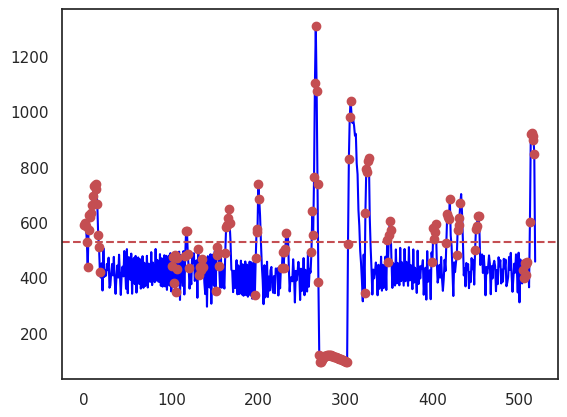

In [319]:
loss = reconstructed_loss(reconstructed_points, data_for_clustering)
label_reshaped = np.max(label_sequences, axis=1)
# Select points with label 1
label_1_indices = np.where(label_reshaped == 1)[0]

#plot loss
plt.plot(range(len(loss)), loss, color='blue', label='Label 0')

# Plot red points for anomalies
plt.plot(label_1_indices, loss[label_1_indices], 'ro', label='Label 1')

# Set the threshold for the line (mean + 3 * std)
threshold = mean_loss + 0.5 * std_loss
plt.axhline(y=threshold, color='r', linestyle='--', label='Mean + 3 * Std')

In [46]:
def find_anomaly_ranges(labels):
    ranges = []
    start = None
    for i, label in enumerate(labels):
        if label == 0 and start is not None:
            ranges.append([start, i - 1])
            start = None
        elif label == 1 and start is None:
            start = i
    if start is not None:
        ranges.append([start, len(labels) - 1])
    return ranges

labels = [1, 1, 1, 0, 0, 1, 1, 1, 1, 0]
anomaly_ranges = find_anomaly_ranges(labels)
print(anomaly_ranges)

[[0, 2], [5, 8]]
